In [ ]:
import sagemaker

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

Download the Fashion-MNIST dataset

In [10]:
import os
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

Upload Fashion-MNIST data to S3

In [11]:
prefix = 'keras-fashion-mnist'

training_input_path   = sess.upload_data('data/training.npz', key_prefix=prefix+'/training')
validation_input_path = sess.upload_data('data/validation.npz', key_prefix=prefix+'/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-2-435269695145/keras-fashion-mnist/training/training.npz
s3://sagemaker-us-east-2-435269695145/keras-fashion-mnist/validation/validation.npz


Train with Tensorflow on the notebook instance (aka 'local mode')

In [12]:
!pygmentize mnist_keras_tf.py

import argparse, os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import multi_gpu_model
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
# from keras.optimizers import SGD
# from keras.utils import multi_gpu_model
# ================================================== Local
from tensorflow.keras.datasets import fashion_mnist
# ================================================== Local

if __name__ == '__main__':
        
    parser = argparse.ArgumentParser()

    ================================================== AWS
    parser.add_argument('--epochs', type=int, defa

In [13]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='mnist_keras_tf.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='local',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 1}
                         )

In [14]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

Using the short-lived AWS credentials found in session. They might expire while running.


FileNotFoundError: [Errno 2] No such file or directory: 'docker': 'docker'

Train with Tensorflow on a GPU instance

In [22]:
tf_estimator = TensorFlow(entry_point='mnist_keras_tf.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m5.xlarge',
                          framework_version='2.3', 
                          py_version='py37',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 20,
                              'batch-size': 256,
                              'learning-rate': 0.01}
                         )

In [23]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

2021-01-30 17:54:11 Starting - Starting the training job...
2021-01-30 17:54:33 Starting - Launching requested ML instancesProfilerReport-1612029250: InProgress
......
2021-01-30 17:55:34 Starting - Preparing the instances for training......
2021-01-30 17:56:35 Downloading - Downloading input data
2021-01-30 17:56:35 Training - Downloading the training image...
2021-01-30 17:56:59 Training - Training image download completed. Training in progress.2021-01-30 17:57:00.500555: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-01-30 17:57:00.504707: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-01-30 17:57:00.652944: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-01-30 17:57:03,472 sagemaker-training-toolkit INFO     Imported framewo

Deploy

In [54]:
import time

# tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_endpoint_name = 'keras-tf-fmnist-endpoint'

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                  instance_type='ml.m4.xlarge',
                                  endpoint_name=tf_endpoint_name)      # $1.361/hour in eu-west-1

# tf_predictor = tf_estimator.deploy(initial_instance_count=1,
#                          instance_type='ml.c5.large',        # $0.134/hour in eu-west-1
#                          accelerator_type='ml.eia1.medium',  # + $0.140/hour in eu-west-1
#                          endpoint_name=tf_endpoint_name)     # = 80% discount!

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

Predict

Predicted labels are: [2 7 6 0 6]


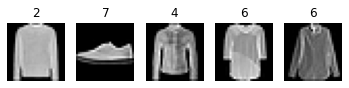

In [58]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

In [50]:
print(tf_endpoint_name)

keras-tf-fmnist-2021-01-30-18-17-52


Clean up

In [59]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name)

In [53]:
tf_predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:435269695145:endpoint/keras-tf-fmnist-2021-01-30-18-17-52".